In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot
import awkward as ak
from pathlib import Path
import joblib

import mplhep as hep

hep.style.use(hep.style.ATLAS)

from typing import Dict, List
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from utils.utils import calculate_significance

In [2]:
weight_str = "WeightNormalized"

# Prepare Samples

In [3]:
merged_sig_path = "../merged_decorated_sig.pkl"
merged_bkg_path = "../merged_decorated_bkg.pkl"

df_signal = joblib.load(merged_sig_path)
df_bkg = joblib.load(merged_bkg_path)

In [4]:
df_signal_groupedby = df_signal.groupby("file_identifer")
size_mass_point = df_signal_groupedby.count()[weight_str].min()

In [35]:
df_signal_groupedby.count()[weight_str]

file_identifer
signal_m1000    60643
signal_m200     12153
signal_m225     23628
signal_m250     27175
signal_m275     29752
signal_m300     30644
signal_m325     35208
signal_m350     37346
signal_m375     39212
signal_m400     42109
signal_m425     42870
signal_m450     40272
signal_m475     46526
signal_m500     46936
signal_m525     55076
signal_m550     56220
signal_m600     57026
signal_m700     61096
signal_m800     61603
signal_m900     62579
Name: WeightNormalized, dtype: int64

In [5]:
new_sig_sample = []
for k, group in df_signal_groupedby:
    new_sig_sample.append(group.sample(size_mass_point, random_state=42))

In [6]:
new_sig_sample = pd.concat(new_sig_sample)

In [7]:
new_bkg_sample = df_bkg.sample(new_sig_sample.shape[0], random_state=42)

In [8]:
joblib.dump(new_sig_sample, "./sig.pkl")
joblib.dump(new_bkg_sample, "./bkg.pkl")

['./bkg.pkl']

# Base Model Training

In [9]:
new_sig_sample = joblib.load("./sig.pkl")
new_bkg_sample = joblib.load("./bkg.pkl")

In [10]:
new_sig_sample.head()

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,file_identifer,target
133383,0,502523,4,18,0.387340,0.0,0.000572,0.001476,1003.134766,682.756348,...,0.993012,0.989141,1.002659,123,123,123,743.338745,0.917976,signal_m1000,1
118561,0,502523,3,18,0.387340,0.0,0.000489,0.001262,854.437927,628.859192,...,0.993012,0.997699,0.984003,123,123,123,825.114075,0.604632,signal_m1000,1
38999,0,502523,2,1516,0.313683,0.0,0.000427,0.001360,1009.914612,658.092957,...,0.986674,0.985825,0.960300,123,123,123,706.120178,0.921484,signal_m1000,1
67901,0,502523,1,17,0.384645,0.0,-0.000748,-0.001944,962.397644,694.456177,...,0.990406,0.973084,0.990401,123,123,123,970.971008,0.431394,signal_m1000,1
126876,0,502523,3,18,0.387340,0.0,0.000305,0.000786,966.813416,902.500549,...,0.986653,1.002659,0.953219,123,123,123,858.208740,0.893886,signal_m1000,1


In [11]:
features = [
    "Deta_jj",
    "Dphi_jj",
    "M_jj",
    "Met",
    "ZetaLep",
    "Jet1Pt",
    "Jet1Eta",
    "Jet2Pt",
    "Jet2Eta",
    "Ht",
    "Eta_W",
    "Eta_Z",
    "Lep1Eta",
    "Lep2Eta",
    "Lep3Eta",
]

In [12]:
n_samples = new_sig_sample.shape[0]
X = pd.concat([new_sig_sample, new_bkg_sample])
y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])

In [13]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1 / 0.9, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train[features])
X_train[features] = scaler.transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [15]:
mlp = MLPClassifier(
    solver="adam",
    alpha=1e-5,
    learning_rate="constant",
    learning_rate_init=0.01,
    hidden_layer_sizes=(50, 50),
    random_state=42,
    verbose=True,
    max_iter=100,
    validation_fraction=0.1,
    early_stopping=True,
    n_iter_no_change=10,
)

mlp.fit(X_train[features], y_train)

Iteration 1, loss = 0.32046420
Validation score: 0.865287
Iteration 2, loss = 0.31241231
Validation score: 0.865570
Iteration 3, loss = 0.31083743
Validation score: 0.866264
Iteration 4, loss = 0.30939769
Validation score: 0.868089
Iteration 5, loss = 0.30837867
Validation score: 0.861455
Iteration 6, loss = 0.30780116
Validation score: 0.867781
Iteration 7, loss = 0.30702955
Validation score: 0.868244
Iteration 8, loss = 0.30675950
Validation score: 0.869607
Iteration 9, loss = 0.30612307
Validation score: 0.867138
Iteration 10, loss = 0.30619797
Validation score: 0.869015
Iteration 11, loss = 0.30550736
Validation score: 0.868038
Iteration 12, loss = 0.30531485
Validation score: 0.868244
Iteration 13, loss = 0.30513802
Validation score: 0.868578
Iteration 14, loss = 0.30487745
Validation score: 0.868527
Iteration 15, loss = 0.30475670
Validation score: 0.867575
Iteration 16, loss = 0.30471807
Validation score: 0.867190
Iteration 17, loss = 0.30444565
Validation score: 0.866958
Iterat

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=100, random_state=42,
              verbose=True)

In [17]:
joblib.dump(scaler, "./base_scaler.pkl")
joblib.dump(mlp, "./base_mlp.pkl")

['./base_mlp.pkl']

## Performance

### Overtraining

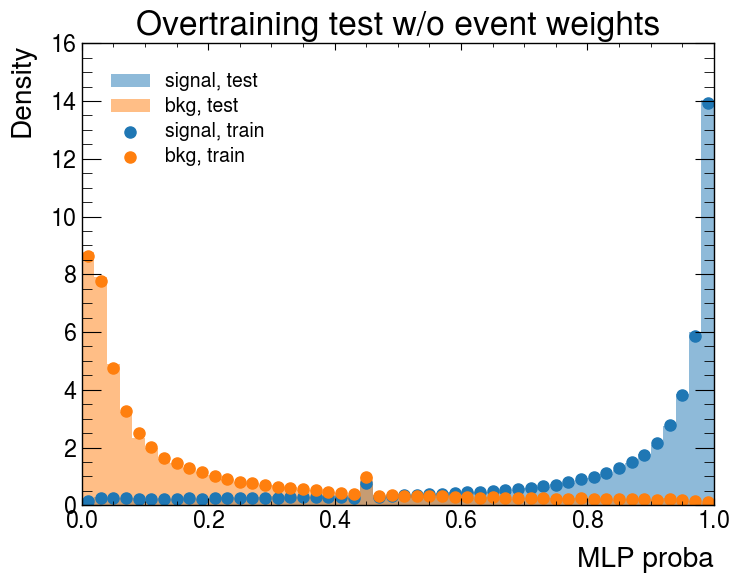

In [18]:
y_test_proba = mlp.predict_proba(X_test[features])[:, 1]
y_train_proba = mlp.predict_proba(X_train[features])[:, 1]

bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(y_test_proba[y_test == 1], bins=bin_edges_proba, density=True, label="signal, test", alpha=0.5)
ax.hist(y_test_proba[y_test == 0], bins=bin_edges_proba, density=True, label="bkg, test", alpha=0.5)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(y_train_proba[y_train == 1], bins=bin_edges_proba, density=True)
y_train_bkg_bin_contents, _ = np.histogram(y_train_proba[y_train == 0], bins=bin_edges_proba, density=True)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("MLP proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/o event weights")
plt.show()

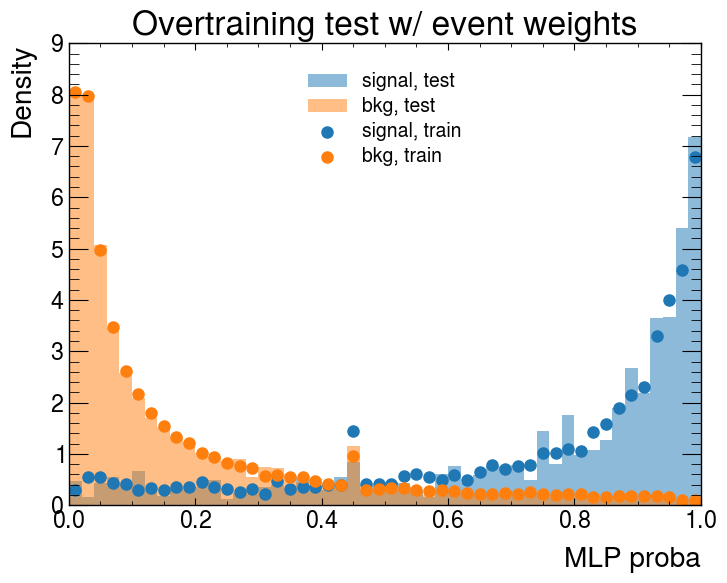

In [19]:
bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(
    y_test_proba[y_test == 1],
    bins=bin_edges_proba,
    weights=X_test.loc[y_test == 1, weight_str],
    density=True,
    label="signal, test",
    alpha=0.5,
)
ax.hist(
    y_test_proba[y_test == 0],
    bins=bin_edges_proba,
    weights=X_test.loc[y_test == 0, weight_str],
    density=True,
    label="bkg, test",
    alpha=0.5,
)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(
    y_train_proba[y_train == 1],
    bins=bin_edges_proba,
    weights=X_train.loc[y_train == 1, weight_str],
    density=True,
)
y_train_bkg_bin_contents, _ = np.histogram(
    y_train_proba[y_train == 0],
    bins=bin_edges_proba,
    weights=X_train.loc[y_train == 0, weight_str],
    density=True,
)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("MLP proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/ event weights")
plt.show()

### ROC

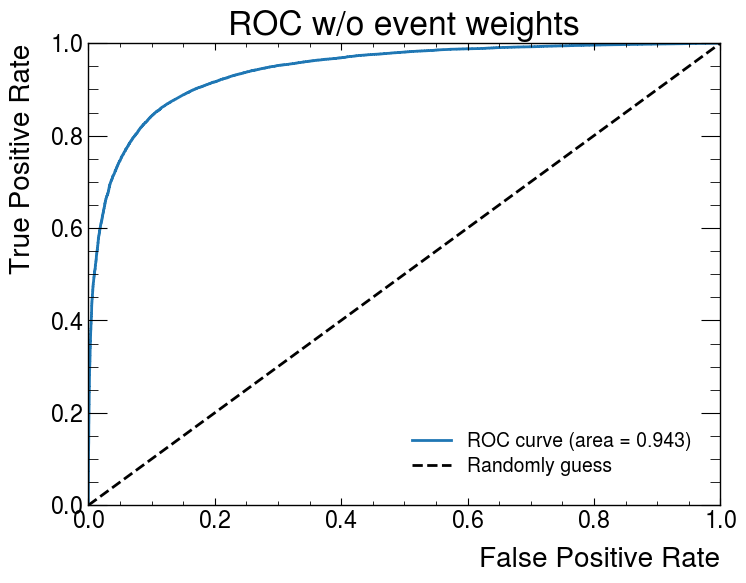

In [20]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Randomly guess")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/o event weights")

plt.show()

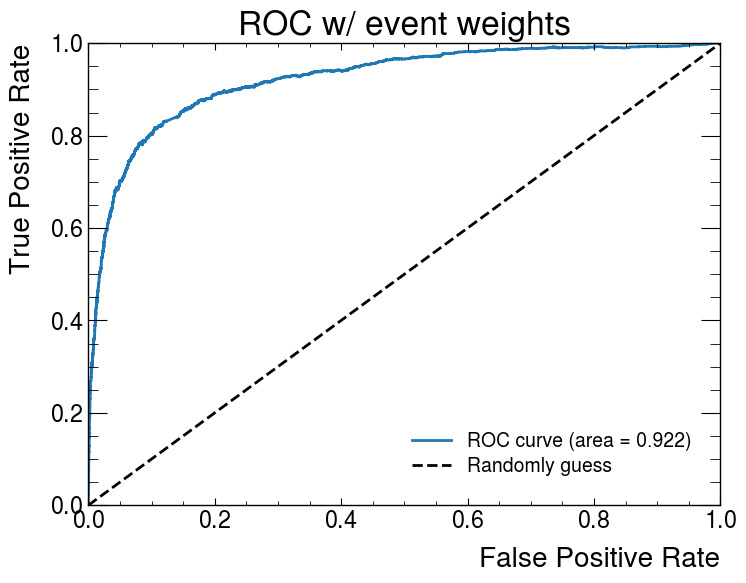

In [21]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, sample_weight=X_test[weight_str])

# sort the thresholds, fpr, tpr by fpr
fpr, tpr, thresholds = zip(*sorted(zip(fpr, tpr, thresholds)))


ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Randomly guess")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/ event weights")

plt.show()

## Significance Optimization

In [50]:
df_signal["mlp_proba"] = mlp.predict_proba(scaler.transform(df_signal[features]))[:, 1]
df_bkg["mlp_proba"] = mlp.predict_proba(scaler.transform(df_bkg[features]))[:, 1]

/opt/homebrew/Caskroom/mambaforge/base/envs/ssWWWZjj/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/ssWWWZjj/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


/Users/yolo/Projects/ssWWWZjj/src/utils/utils.py:49: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))


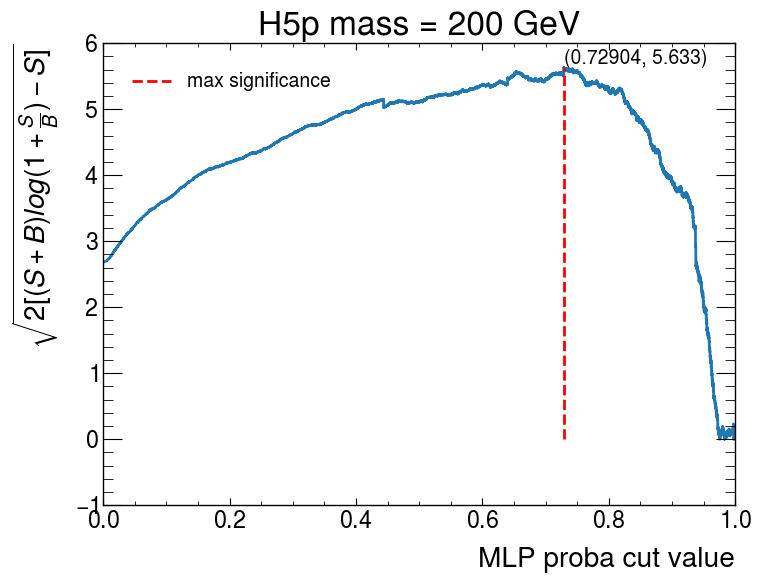

In [51]:
df_signal_groubpy = df_signal.groupby("file_identifer")
df_signal_m200 = df_signal_groubpy.get_group("signal_m200")

combined = pd.concat([df_signal_m200, df_bkg])
fpr, tpr, thresholds = roc_curve(
    combined["target"], combined["mlp_proba"], sample_weight=combined[weight_str]
)

n_sig = df_signal_m200[weight_str].sum()
n_bkg = df_bkg[weight_str].sum()

S = n_sig * tpr
B = n_bkg * fpr
metric = calculate_significance(S, B)

arg_idx = np.argmax(metric[1:])


plt.plot(thresholds, metric)
plt.xlabel("MLP proba cut value")
plt.ylabel("$\\sqrt{2 [(S +B ) log(1+\\frac{S}{B}) - S] }$")
plt.title("H5p mass = 200 GeV")
plt.xlim(0, 1.0)
plt.vlines(
    thresholds[arg_idx], 0, metric[arg_idx + 1], color="r", linestyle="--", label=f"max significance"
)
plt.text(
    thresholds[arg_idx],
    metric[arg_idx + 1],
    f"({thresholds[arg_idx]:.5f}, {metric[arg_idx+1]:.3f})",
    ha="left",
    va="bottom",
)
plt.legend()

### Investigate

Figured out, remember to scale the input dataset. 

In [46]:
X_train["mlp_proba"] = y_train_proba
X_test["mlp_proba"] = y_test_proba

/Users/yolo/Projects/ssWWWZjj/src/utils/utils.py:49: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))
/Users/yolo/Projects/ssWWWZjj/src/utils/utils.py:49: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))
/Users/yolo/Projects/ssWWWZjj/src/utils/utils.py:49: RuntimeWarning: invalid value encountered in log
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))
/Users/yolo/Projects/ssWWWZjj/src/utils/utils.py:49: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))
/opt/homebrew/Caskroom/mambaforge/base/envs/ssWWWZjj/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


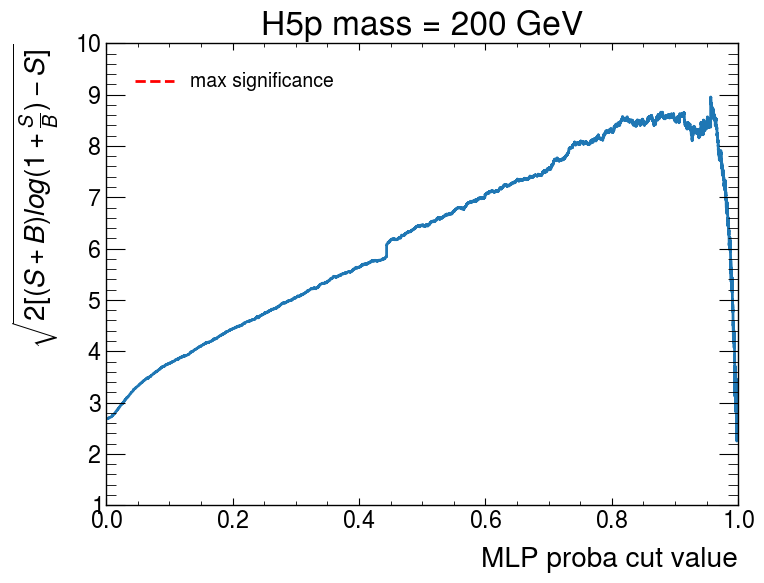

In [34]:
fpr, tpr, thresholds = roc_curve(X_test["target"], X_test["mlp_proba"], sample_weight=X_test[weight_str])

n_sig = df_signal_m200[weight_str].sum()
n_bkg = df_bkg[weight_str].sum()

S = n_sig * tpr
B = n_bkg * fpr
metric = calculate_significance(S, B)

arg_idx = np.argmax(metric[1:])


plt.plot(thresholds, metric)
plt.xlabel("MLP proba cut value")
plt.ylabel("$\\sqrt{2 [(S +B ) log(1+\\frac{S}{B}) - S] }$")
plt.title("H5p mass = 200 GeV")
plt.xlim(0, 1.0)
plt.vlines(
    thresholds[arg_idx], 0, metric[arg_idx + 1], color="r", linestyle="--", label=f"max significance"
)
plt.text(
    thresholds[arg_idx],
    metric[arg_idx + 1],
    f"({thresholds[arg_idx]:.5f}, {metric[arg_idx+1]:.3f})",
    ha="left",
    va="bottom",
)
plt.legend()

In [52]:
df_signal_m200 = df_signal_groubpy.get_group("signal_m200")
df_test_m200 = X_test.groupby("file_identifer").get_group("signal_m200")
df_train_m200 = X_train.groupby("file_identifer").get_group("signal_m200")

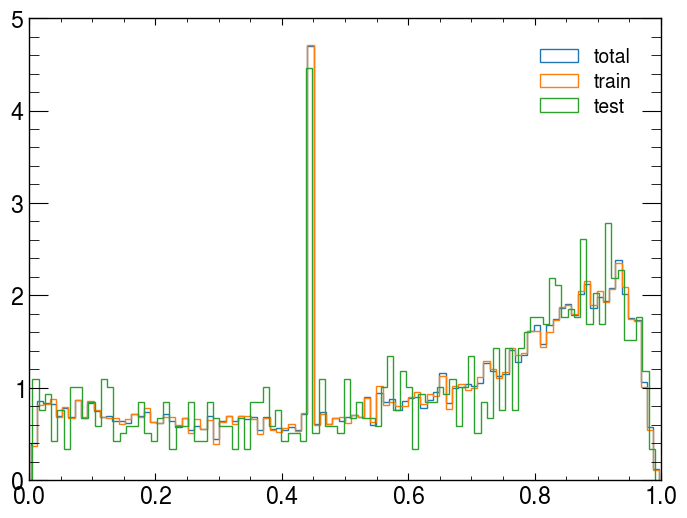

In [53]:
plt.hist(df_signal_m200["mlp_proba"], bins=100, label="total", density=True, histtype="step")
plt.hist(df_train_m200["mlp_proba"], bins=100, label="train", density=True, histtype="step")
plt.hist(df_test_m200["mlp_proba"], bins=100, label="test", density=True, histtype="step")
plt.legend()

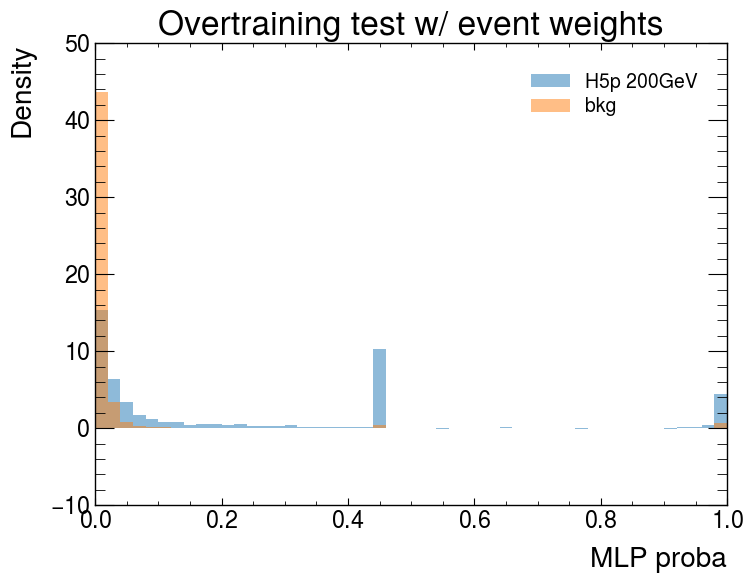

In [28]:
bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(
    df_signal_m200["mlp_proba"],
    bins=bin_edges_proba,
    weights=df_signal_m200[weight_str],
    density=True,
    label="H5p 200GeV",
    alpha=0.5,
)
ax.hist(
    df_bkg["mlp_proba"],
    bins=bin_edges_proba,
    weights=df_bkg[weight_str],
    density=True,
    label="bkg ",
    alpha=0.5,
)

ax.legend()
ax.set_xlabel("MLP proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/ event weights")
plt.show()

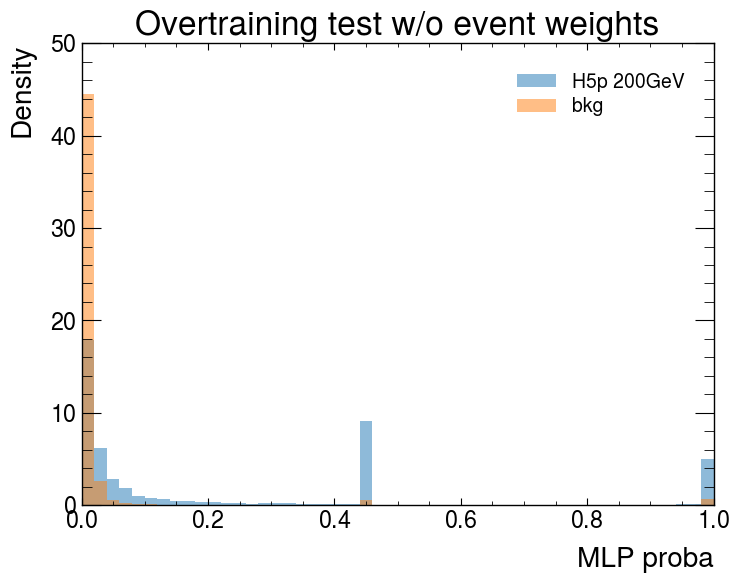

In [29]:
bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(df_signal_m200["mlp_proba"], bins=bin_edges_proba, density=True, label="H5p 200GeV", alpha=0.5)
ax.hist(df_bkg["mlp_proba"], bins=bin_edges_proba, density=True, label="bkg ", alpha=0.5)

ax.legend()
ax.set_xlabel("MLP proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/o event weights")
plt.show()

# The Best Model

In [54]:
import optuna
from optuna.samplers import TPESampler

In [55]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-5, 1),
        "first_layer_neurons": trial.suggest_int("first_layer_neurons", 10, 100, step=10),
        "second_layer_neurons": trial.suggest_int("second_layer_neurons", 10, 100, step=10),
        "alpha": trial.suggest_float("alpha", 1e-5, 1),
    }

    # use 1/9 of the dev set as the validation set and set the early stopping criteria
    mlp = MLPClassifier(
        hidden_layer_sizes=(param["first_layer_neurons"], param["second_layer_neurons"]),
        learning_rate_init=param["learning_rate_init"],
        alpha=param["alpha"],
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=0.0001,
    )
    mlp.fit(X_train[features], y_train)

    # choose the highest auc score with event weight
    y_val_decisions = mlp.predict_proba(scaler.transform(X_val[features]))[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_decisions, sample_weight=X_val[weight_str])
    # sort the fpr and tpr and thresholds in ascending order of fpr
    fpr, tpr, thresholds = zip(*sorted(zip(fpr, tpr, thresholds)))
    roc_auc = auc(fpr, tpr)

    return roc_auc


sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler, study_name="sklearn MLP training")
study.optimize(objective, n_trials=100, n_jobs=1)

: 

: 